# AquaCrop-OSPy: Bridging the gap between research and practice in crop-water modelling


This series of notebooks provides users with an introduction to AquaCrop-OSPy, an open-source Python implementation of the U.N. Food and Agriculture Organization (FAO) AquaCrop model. AquaCrop-OSPy is accompanied by a series of Jupyter notebooks, which guide users interactively through a range of common applications of the model. Only basic Python experience is required, and the notebooks can easily be extended and adapted by users for their own applications and needs.


This notebook series consists of four parts:

1.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_1.ipynb>Running an AquaCrop-OSPy model</a>
2.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_2.ipynb>Estimation of irrigation water demands</a>
3.   <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_3.ipynb>Optimisation of irrigation management strategies</a>
4.  <a href=https://colab.research.google.com/github/thomasdkelly/aquacrop/blob/master/tutorials/AquaCrop_OSPy_Notebook_4.ipynb>Projection of climate change impacts</a>


# Notebook 3: Developing and optimizing irrigation stratgeies 

In the previous notebook, we looked at how to simulate yields and water use for different pre-specified irrigation management practices or rules. However, what if you wanted to know which strategy would give you the maximum yield for a given amount of irrigation water use? In this notebook, we look at how optimal irrigation schedules can be identified by linking AquaCrop-OSPy with one of the many optimization modules in available in the python ecosystem.

Our specific example focuses on optimizing soil-moisture thresholds which are commonly used both in practice and literature on optimizing irrigation decisions. During the growing season, if the soil-moisture content drops below the threshold, irrigation is applied to refill the soil profile back to field capacity subject to a maximum irrigation depth. AquaCrop-OSPy allows you to define four thresholds corresponding to four main growing periods (emergence, canopy growth, max canopy and senescence). Changing the threshold depending on crop growth stage reflects the fact that crop water requirements and drought stress responses vary over the course of the season. 

Using the optimization library `scipy.optimize` we will find sets of soil-moisture thresholds that maximize yields for a Maize crop located in Champion Nebraska. The optimization will be repeated for different water supply constraints (maximum amount of water that can be applied in a given season). The simulation will take place over 3 years (2016-2018).

Import and install AquaCrop-OSPy

In [1]:
# !pip install aquacrop==0.2

# from aquacrop.classes import    *
# from aquacrop.core import       *

# from google.colab import output
# output.clear()

In [2]:
# only used for local development

import sys
_=[sys.path.append(i) for i in ['.', '..']]

from aquacrop.classes import    *
from aquacrop.core import       *

In [3]:
path = get_filepath('champion_climate.txt')
wdf = prepare_weather(path)

Define a function called `run_model` that creates and runs an AquaCrop model (just like in the previous notebooks), and returns the final output.

In [4]:
def run_model(smts,max_irr_season,year1,year2):
    """
    funciton to run model and return results for given set of soil moisture targets
    """

    maize = CropClass('Maize',PlantingDate='05/01') # define crop
    loam = SoilClass('ClayLoam') # define soil
    init_wc = InitWCClass(wc_type='Pct',value=[70]) # define initial soil water conditions

    irrmngt = IrrMngtClass(IrrMethod=1,SMT=smts,MaxIrrSeason=max_irr_season) # define irrigation management

    # create and run model
    model = AquaCropModel(f'{year1}/05/01',f'{year2}/10/31',wdf,loam,maize,
                          IrrMngt=irrmngt,InitWC=init_wc)
    model.initialize()
    model.step(till_termination=True)
    return model.Outputs.Final


In [5]:
run_model([70]*4,300,2018,2018)

,Season,Crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,2018-09-16,137,14.240747,300.0


Define `evaluate` will act as a reward function for the optimization library to optimize. Inside this function we run the model and return the reward (in this case the average yield).


In [6]:
import numpy as np # import numpy library

def evaluate(smts,max_irr_season,test=False):
    """
    funciton to run model and calculate reward (yield) for given set of soil moisture targets
    """
    # run model
    out = run_model(smts,max_irr_season,year1=2016,year2=2018)
    # get yields and total irrigation
    yld = out['Yield (tonne/ha)'].mean()
    tirr = out['Seasonal irrigation (mm)'].mean()

    reward=yld

    # return either the negative reward (for the optimization)
    # or the yield and total irrigation (for analysis)
    if test:
        return yld,tirr,reward
    else:
        return -reward


In [7]:
evaluate([70]*4,300)

-13.34649322842047

Define `get_starting_point` that chooses a set of random irrigation strategies and evaluates them to give us a good starting point for our optimization. (Since we are only using a local minimization function this will help get a good result)

In [8]:
def get_starting_point(num_smts,max_irr_season,num_searches):
    """
    find good starting threshold(s) for optimization
    """

    # get random SMT's
    x0list = np.random.rand(num_searches,num_smts)*100
    rlist=[]
    # evaluate random SMT's
    for xtest in x0list:
        r = evaluate(xtest,max_irr_season,)
        rlist.append(r)

    # save best SMT
    x0=x0list[np.argmin(rlist)]
    
    return x0

In [9]:
get_starting_point(4,300,10)

array([54.55006524, 61.304644  , 60.43616017, 59.33358653])

Define `optimize` that uses the `scipy.optimize.fmin` optimization package to find yield maximizing irrigation strategies for a maximum seasonal irrigation limit. 


In [10]:
from scipy.optimize import fmin

def optimize(num_smts,max_irr_season,num_searches=100):
    """ 
    optimize thresholds to be profit maximising
    """
    # get starting optimization strategy
    x0=get_starting_point(num_smts,max_irr_season,num_searches)
    # run optimization
    res = fmin(evaluate, x0,disp=0,args=(max_irr_season,))
    # reshape array
    smts= res.squeeze()
    # evaluate optimal strategy
    return smts

In [11]:
smts=optimize(4,300)

In [12]:
evaluate(smts,300,True)

(13.906724094616036, 300.0, 13.906724094616036)

For a range of maximum seasonal irrigation limits (0-450mm), find the yield maximizing irrigation schedule.

In [13]:
from tqdm.notebook import tqdm # progress bar

opt_smts=[]
yld_list=[]
tirr_list=[]
for max_irr in tqdm(range(0,500,50)):
    

    # find optimal thresholds and save to list
    smts=optimize(4,max_irr)
    opt_smts.append(smts)

    # save the optimal yield and total irrigation
    yld,tirr,_=evaluate(smts,max_irr,True)
    yld_list.append(yld)
    tirr_list.append(tirr)

  0%|          | 0/10 [00:00<?, ?it/s]

Visualize the optimal yield and total irrigation, creating a crop-water production function.

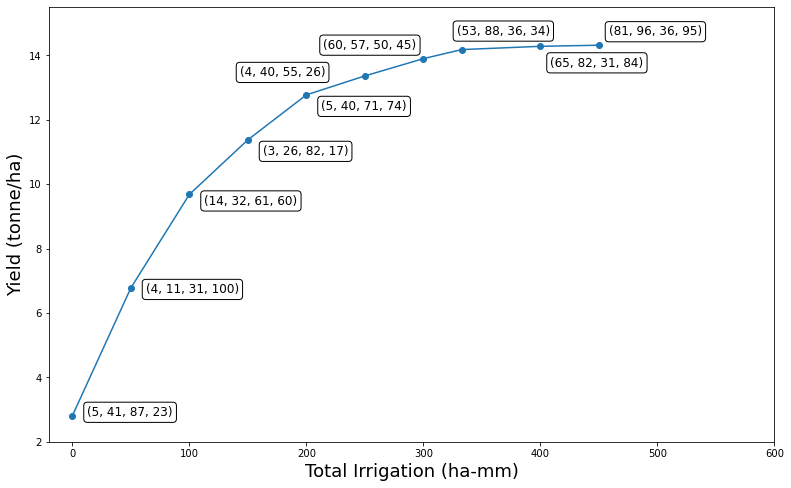

In [14]:
# import plotting library
import matplotlib.pyplot as plt

# create plot
fig,ax=plt.subplots(1,1,figsize=(13,8))

# plot results
ax.scatter(tirr_list,yld_list)
ax.plot(tirr_list,yld_list)

# labels
ax.set_xlabel('Total Irrigation (ha-mm)',fontsize=18)
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)
ax.set_xlim([-20,600])
ax.set_ylim([2,15.5])

# annotate with optimal thresholds
bbox = dict(boxstyle="round",fc="1")
offset = [15,15,15, 15,15,-125,-100,  -5, 10,10]
yoffset= [0,-5,-10,-15, -15,  0,  10,15, -20,10]
for i,smt in enumerate(opt_smts):
    smt=smt.clip(0,100)
    ax.annotate('(%.0f, %.0f, %.0f, %.0f)'%(smt[0],smt[1],smt[2],smt[3]),
                (tirr_list[i], yld_list[i]), xytext=(offset[i], yoffset[i]), textcoords='offset points',
                bbox=bbox,fontsize=12)



Note that fmin is a local optimizer and so optimal soil-moisture thresholds will vary over multiple repetitions

# Appendix: Parrallel

Can also speed things up with a parallel approach. Though for Colab notebooks there are only 2 CPUs so we are not expecting a massive speed up. But this kind of approach can be useful when more CPUs are available either locally or in cloud computing infestructure. 

In [15]:
# import multiprocessing library
from multiprocessing import Pool

# time library so we can check the speed up
from time import time

# define funciton to parallelize
def func(max_irr):

    # find optimal smts
    smts=optimize(4,max_irr)

    # return the optimal yield, total irrigaiton and thresholds
    yld,tirr,_=evaluate(smts,max_irr,True)
    print(f"finished max_irr = {max_irr} at {round(time()-start)} seconds")
    return yld,tirr,smts


Multi processing in python can be done using the `Pool` object. The code below create a `Pool` object, passing in the number of CPU cores that you want to parallelize over. Then use `p.map` to evaluate the function `func` for each input given in the list. 

In [16]:
start = time() # save start time 
with Pool(2) as p:
    results = p.map(func, list(range(0,500,50)))

finished max_irr = 0 at 15 seconds
finished max_irr = 100 at 17 seconds
finished max_irr = 50 at 31 seconds
finished max_irr = 150 at 34 seconds
finished max_irr = 200 at 49 seconds
finished max_irr = 300 at 51 seconds
finished max_irr = 250 at 66 seconds
finished max_irr = 350 at 70 seconds
finished max_irr = 400 at 84 seconds
finished max_irr = 450 at 104 seconds


This approach in Colab does not give us a massive speed up, however this approach can be a big help if more CPU cores are available. Combine results for visualization.

In [17]:
parr_opt_smts=[]
parr_yld_list=[]
parr_tirr_list=[]
for i in range(len(results)):
    parr_yld_list.append(results[i][0])
    parr_tirr_list.append(results[i][1])
    parr_opt_smts.append(results[i][2])

Plot crop-water production function.

Text(0, 0.5, 'Yield (tonne/ha)')

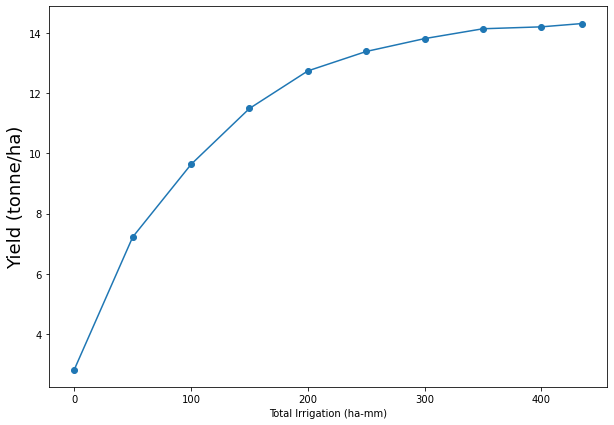

In [18]:
fig,ax=plt.subplots(1,1,figsize=(10,7))

ax.scatter(parr_tirr_list,parr_yld_list)
ax.plot(parr_tirr_list,parr_yld_list)

ax.set_xlabel('Total Irrigation (ha-mm)')
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)